In [3]:
!pip install  tensorflow matplotlib

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os

In [5]:
!wget -O fruits-360.zip https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
!unzip -qq fruits-360.zip

--2025-11-06 02:13:31--  https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master [following]
--2025-11-06 02:13:31--  https://codeload.github.com/Horea94/Fruit-Images-Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip          [      <=>           ] 761.30M  29.6MB/s    in 28s     

2025-11-06 02:14:00 (27.1 MB/s) - ‘fruits-360.zip’ saved [798281972]

replace Fruit-Images-Dataset-master/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
train_dir = 'Fruit-Images-Dataset-master/Training'
test_dir = 'Fruit-Images-Dataset-master/Test'

IMG_size = (64,64)
BATCH_SIZE = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_size,
    batch_size=BATCH_SIZE,
    shuffle = True
)

Found 67692 files belonging to 131 classes.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_size,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected fruit classes:", num_classes)

Found 22688 files belonging to 131 classes.
Detected fruit classes: 131


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
#

In [10]:
model = models.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(64, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.GlobalAveragePooling2D(),
                           layers.Dense(256, activation='relu'),
                           layers.Dropout(0.3),
                           layers.Dense(num_classes, activation = 'softmax')])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131)            │        33,667 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,939 (624.76 KB)

 Trainable params: 159,939 (624.76 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4231/4231 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - accuracy: 0.4394 - loss: 2.0534 - val_accuracy: 0.8786 - val_loss: 0.4260
Epoch 2/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9138 - loss: 0.2570 - val_accuracy: 0.8923 - val_loss: 0.3513
Epoch 3/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9493 - loss: 0.1508 - val_accuracy: 0.9198 - val_loss: 0.2830
Epoch 4/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9657 - loss: 0.1040 - val_accuracy: 0.9600 - val_loss: 0.1690
Epoch 5/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9749 - loss: 0.0765 - val_accuracy: 0.9609 - val_loss: 0.2156
Epoch 6/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9776 - loss: 0.0666 - val_accuracy: 0.9681 - val_loss: 0.2036
Epoch 7/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9828 - loss: 0.0526 - val_accuracy: 0.9740 - val_loss: 0.1549
Epoch 8/15
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9870 - loss: 0.0448 - va

Text(0.5, 1.0, 'Accuracy')

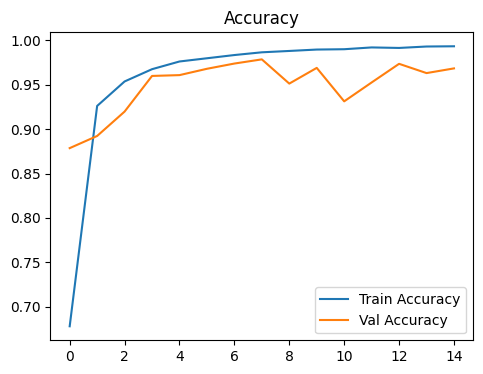

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

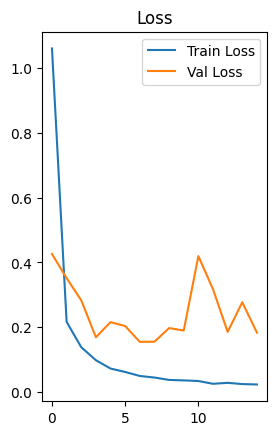

In [13]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [14]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9693 - loss: 0.1800
Test accuracy : 0.9685296416282654


Saving fruit.jpg to fruit (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


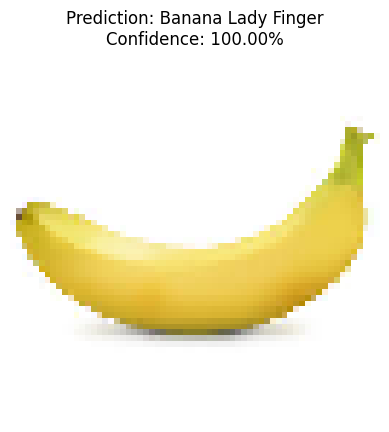

In [22]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  img = load_img(fn, target_size=IMG_size)
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  predictions = model.predict(img_array)
  label = class_names[np.argmax(predictions)]
  conf = np.max(predictions) * 100

  plt.imshow(img)
  plt.title(f'Prediction: {label}\nConfidence: {conf:.2f}%')
  plt.axis('off')
  plt.show()